<a href="https://colab.research.google.com/github/changsin/CV/blob/main/01_14_pixels_lens_distortion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image formation: Pixels: lens distortion

The following are exercises done for Hany Faird's [Computer Vision course](https://youtube.com/playlist?list=PLhwIOYE-ldwL6h-peJADfNm8bbO3GlKEy&si=sXmtTvaJDQb6QD20)

#01-14 [Image formation: pixels: lens distortion](https://www.youtube.com/watch?v=hY4Dvw2A_PI&list=PLhwIOYE-ldwL6h-peJADfNm8bbO3GlKEy&index=14).



In [ ]:
!pip install opencv-python

In [2]:
!pip install warping

ERROR: Could not find a version that satisfies the requirement warping (from versions: none)
ERROR: No matching distribution found for warping


In [1]:
from warping import *
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt

# load square, grayscale image
im = Image.open('/content/HanyFaridDistort.png')
[ydim, xdim] = im.size
mid = round(max(xdim,ydim)/2)

# define sampling lattices
n = 100 # lattice sampling
dst = gridify(shape_to_rect(im.size), n, n) # destination grid
src = dst # source grid

# define new sampling lattice (src)
k = 0.0000005 # estimated lens distortion
dst = dst - mid # put image center at (0,0)

#############################
# you code here -- define src
for i in range(n+1):
  for j in range(n+1):
    x = dst[i,j,0]
    y = dst[i,j,1]
    r = np.sqrt(x**2 + y**2)
    src[i,j,0] = x*(1+k*r**2)
    src[i,j,1] = y*(1+k*r**2)
#############################

dst = dst + mid # re-center
dst = dst.astype(int) # convert to integers
src = src + mid # re-center
src = src.astype(int) # convert to integers

# warp image
mesh = grid_to_mesh(src, dst)
imt = im.transform(im.size, Image.MESH, mesh)
plt.figure(figsize=(ydim/72,xdim/72))
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imt, cmap='gray')
plt.show()

ModuleNotFoundError: No module named 'warping'

# 1.14.1 Lens distortions

## 1.14.1.1 Radial distortion
Imperfections in the lens shape (common in wide-angle lenses) cause straight lines appear curved, especially far from the image center.

$$
\begin{aligned}
r^2 &= x^2 + y^2 \\
x_d &= x \, (1 + k_1 r^2 + k_2 r^4 + k_3 r^6 + \dots) \\
y_d &= y \, (1 + k_1 r^2 + k_2 r^4 + k_3 r^6 + \dots)
\end{aligned}
$$

- $ r $: radial distance from the center
- $ k_1, k_2, k_3 $: radial distortion coefficients
- $ x, y $: coordinates in the original image plane
- $ x_d, y_d $: coordinates in the distorted image plane


For practical purposes, two coefficients are enough:

$$
\begin{aligned}
r^2 &= x^2 + y^2 \\
x_d &= x \, (1 + k_1 r^2 + k_2 r^4) \\
y_d &= y \, (1 + k_1 r^2 + k_2 r^4)
\end{aligned}
$$

- $ k_1, k_2 $: radial distortion coefficients
- $ x, y $: coordinates in the original image plane
- $ x_d, y_d $: coordinates in the distorted image plane
- $ r $: radial distance from the center

## 1.14.1.2 Tangential distortion

$$
x_d = x + 2p_1 x y + p_2 (r^2 + 2x^2) \\
y_d = y + p_1 (r^2 + 2y^2) + 2p_2 x y
$$



$ x_d, y_d $: coordinates in the distorted image plane

$ p_1, p_2 $ = tangential distortion coefficients




### 1.14.1.3 Combined (Radial + Tangential)

\begin{aligned}
r^2 &= x^2 + y^2 \\[6pt]
x_d &= x \left( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right)
     + 2p_1 x y + p_2 \left( r^2 + 2x^2 \right) \\[6pt]
y_d &= y \left( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \right)
     + p_1 \left( r^2 + 2y^2 \right) + 2p_2 x y
\end{aligned}



$ k_1, k_2, k_3 $ = radial distortion coefficients

$ p_1, p_2, p_3 $ = tangential distortion coefficients

$ r $: radial distance from the center

# 1.14.2 Lab: Simulate distortions

## 1.14.2.1 Radial distortion

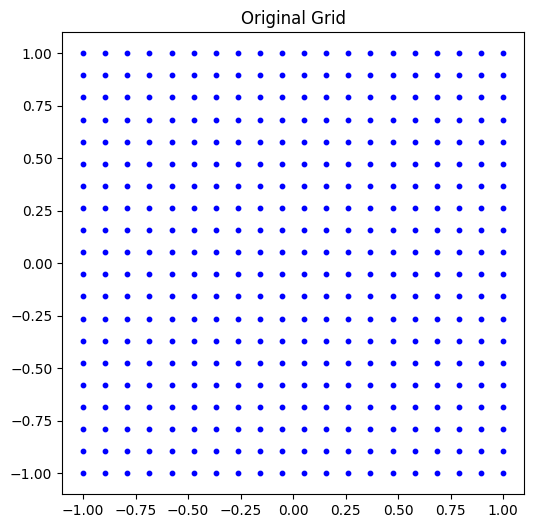

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Grid size
grid_size = 20
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(6,6))
plt.scatter(X, Y, c="blue", s=10)
plt.title("Original Grid")
plt.gca().set_aspect('equal')
plt.show()


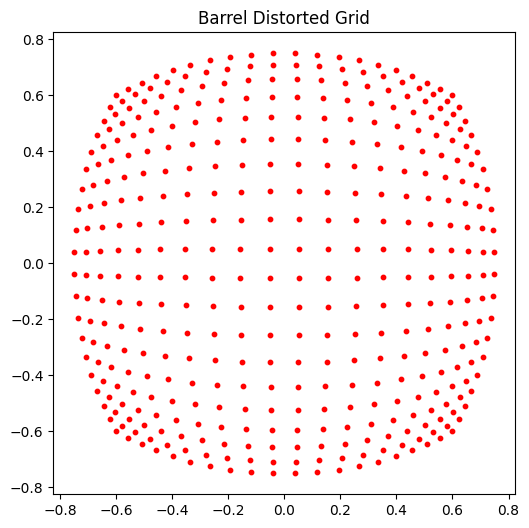

In [2]:
# Distortion coefficients
k1, k2 = -0.3, 0.05

# Radial distortion
R2 = X**2 + Y**2
X_d = X * (1 + k1*R2 + k2*R2**2)
Y_d = Y * (1 + k1*R2 + k2*R2**2)

plt.figure(figsize=(6,6))
plt.scatter(X_d, Y_d, c="red", s=10)
plt.title("Barrel Distorted Grid")
plt.gca().set_aspect('equal')
plt.show()


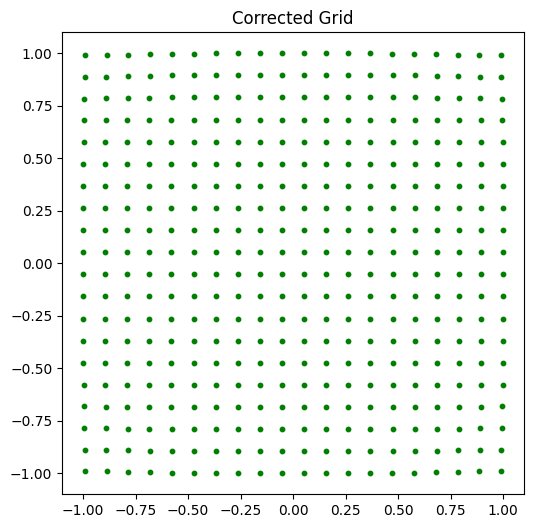

In [6]:
def undistort(xd, yd, k1, k2, iterations=10):
    # Start with initial guess = distorted points
    xu, yu = xd.copy(), yd.copy()
    for _ in range(iterations):
        r2 = xu**2 + yu**2
        factor = 1 + k1*r2 + k2*r2**2
        xu = xd / factor
        yu = yd / factor
    return xu, yu

X_u, Y_u = undistort(X_d, Y_d, k1, k2)

plt.figure(figsize=(6,6))
plt.scatter(X_u, Y_u, c="green", s=10)
plt.title("Corrected Grid")
plt.gca().set_aspect('equal')
plt.show()


## 1.14.2.2 Barrel distortion on an image

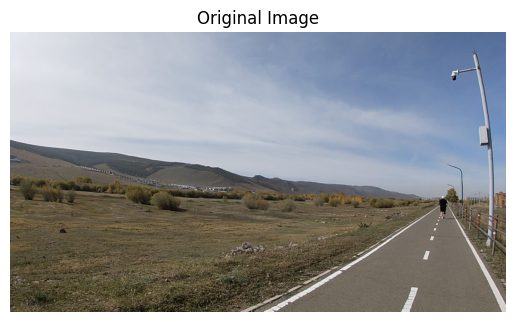

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale for simplicity, or use cv2.IMREAD_COLOR)
img = cv2.imread("/content/National_Park_trail.png", cv2.IMREAD_COLOR)
h, w = img.shape[:2]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()


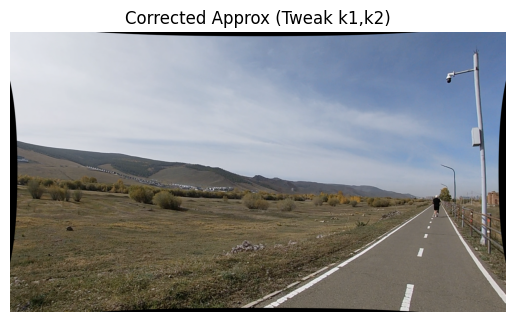

In [4]:
import numpy as np

def undistort_coords(xd, yd, k1, k2, iters=5):
    xu, yu = xd.copy(), yd.copy()
    for _ in range(iters):
        r2 = xu**2 + yu**2
        factor = 1 + k1*r2 + k2*r2**2
        xu = xd / factor
        yu = yd / factor
    return xu, yu

def undistort_image(img, k1=-0.3, k2=0.05):
    h, w = img.shape[:2]
    xx, yy = np.meshgrid(np.linspace(-1,1,w), np.linspace(-1,1,h))

    xu, yu = undistort_coords(xx, yy, k1, k2)
    map_x = ((xu+1)*0.5*(w-1)).astype(np.float32)
    map_y = ((yu+1)*0.5*(h-1)).astype(np.float32)

    return cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)

corrected = undistort_image(img, k1=-0.1, k2=0.07)

plt.imshow(cv2.cvtColor(corrected, cv2.COLOR_BGR2RGB))
plt.title("Corrected Approx (Tweak k1,k2)")
plt.axis("off")
plt.show()
